## Proportional representation of UK constituencies

The idea behind this project is to see how a proportional representation system would have altered results in the last UK general election. The plan is to merge neighbouring constituencies in the UK into 'super' constituencies with 2 / 3 / 4 / etc of them merged together into a larger one and use the D'Hondt method to allocate seats in this 'super' constituency.

In [13]:
import numpy as np
import pandas as pd
import geopandas as gp

import seaborn as sns

import time
# import matplotlib.pyplot as plt

%matplotlib inline

#### Simple PR model
The simplest PR model would multiply the percentage of votes gained nationally by the number of seats in the UK parliament (650). Which can be done simply using the following:

In [2]:
bes = pd.read_csv("../Data/bes_2019.csv")
bes = bes.rename(columns = 
                             {'con_vote_19': 'Conservative',
                             'lab_vote_19': 'Labour',
                             'ld_vote_19': 'Liberal Democrat',
                             'brexit_vote_19': 'Brexit party',
                             'green_vote_19': 'Green',
                             'snp_vote_19': 'Scottish National Party',
                             'pc_vote_19': 'Plaid Cymru',
                             'dup_vote_19': 'Democratic Unionist Party',
                             'sf_vote_19': 'Sinn Fein',
                             'sdlp_vote_19': 'Social Democratic & Labour Party',
                             'uup_vote_19': 'Ulster Unionist Party',
                             'alliance_vote_19': 'Alliance',
                             'other_vote_19': 'Other'})
bes_votes = bes[['total_vote_19', 'Conservative', 'Labour', 'Liberal Democrat',
                 'Brexit party', 'Green', 'Scottish National Party', 'Plaid Cymru',
                 'Democratic Unionist Party', 'Sinn Fein', 'Social Democratic & Labour Party', 
                 'Ulster Unionist Party', 'Alliance', 'Other']]
# Get total votes for each party
# Multiply by 649 as we remove the speaker's constituency
party_votes = bes_votes.fillna(0).apply(sum)
party_proportion = party_votes / party_votes['total_vote_19']
party_proportion = party_proportion.drop('total_vote_19')
list_pr_seats1 = pd.DataFrame(np.round(party_proportion * 649))
list_pr_seats1 = list_pr_seats1.rename(columns={0: 'orig_simple_pr'})

# Have a lot of votes for 'Other', so will remove them for this analysis since they can be spread across the whole country and it would be 
# difficult to know where to allocate the seats for them
party_proportion = party_votes / (party_votes['total_vote_19'] - party_votes['Other'])
party_proportion = party_proportion.drop(['Other','total_vote_19'])
list_pr_seats2 = pd.DataFrame(np.round(party_proportion * 649))
list_pr_seats2 = list_pr_seats2.rename(columns={0: 'simple_pr'})

In [3]:
seats = pd.DataFrame(pd.value_counts(bes['winner_19']))
seats = seats.rename(columns={'winner_19': 'FPTP'})
seats = seats.drop('Speaker')
seats = pd.concat([seats, list_pr_seats1, list_pr_seats2], axis = 1).fillna(0)
seats = seats.reset_index()
seats = seats.rename(columns={'index': 'Party'})

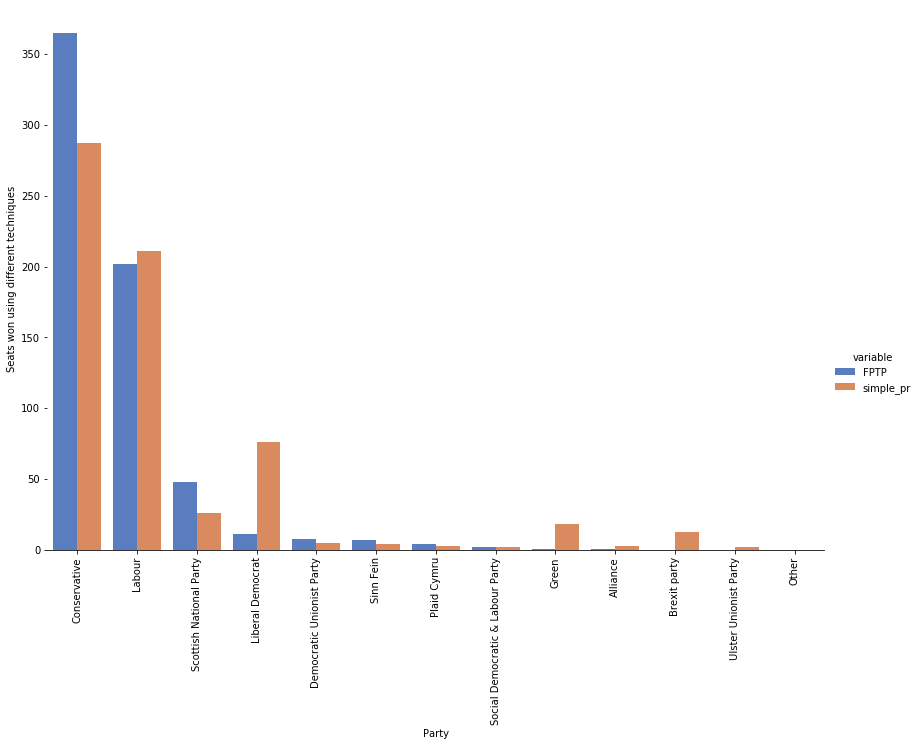

In [4]:
seats2 = pd.melt(seats, id_vars=['Party'], value_vars = ['FPTP', 'simple_pr'])
g = sns.catplot(x="Party", y="value", data=seats2, hue='variable', height=8.27, aspect=11.7/8.27,
                kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("Seats won using different techniques")
g.set_xticklabels(rotation=90)

We can see clearly that the Conservatives and SNP would have a much lower number of seats under this simple PR method, with the beneficiaries being the Liberal Democrats, Greens and the Brexit party.

#### D'Hondt method
As an initial model we shall apply the D'Hondt method to each statistical region in the UK and see what the results would have been in this scenario.

In [5]:
# Function to allocate seats using the D'Hont method
def seat_allocation(votes, no_of_seats=None, method = 'dhondt'):
    if no_of_seats is None:
        no_of_seats = len(votes)
    aggregated_votes = votes.apply(sum)
    aggregated_votes = aggregated_votes[aggregated_votes > 0]
    aggregated_votes = pd.DataFrame(aggregated_votes)
    aggregated_votes = aggregated_votes.rename(columns={0: 'Total votes'})
    aggregated_votes = aggregated_votes.assign(
        seats = 0,
        votes = aggregated_votes['Total votes']
    )
    for i in range(no_of_seats):
        name = aggregated_votes.index[np.argmax(aggregated_votes['votes'])]
        aggregated_votes.at[name, 'seats'] += 1
        if method == 'dhondt':
            aggregated_votes.at[name, 'votes'] = aggregated_votes.at[name, 'Total votes'] / (aggregated_votes.at[name, 'seats'] + 1)
        elif method == 'webster':
            aggregated_votes.at[name, 'votes'] = aggregated_votes.at[name, 'Total votes'] / (2*aggregated_votes.at[name, 'seats'] + 1)
    return aggregated_votes

In [6]:
parties =['Conservative', 'Labour', 'Liberal Democrat',
                 'Brexit party', 'Green', 'Scottish National Party', 'Plaid Cymru',
                 'Democratic Unionist Party', 'Sinn Fein', 'Social Democratic & Labour Party', 
                 'Ulster Unionist Party', 'Alliance'] #, 'Other']
dhont_dict = {}
# Remove Speaker's constituency. 
bes2 = bes[bes['constituency_name'] != 'Chorley'].copy()
for region in np.unique(bes['region']):
    df = bes2[bes2['region'] == region][parties].fillna(0)
    dhont_dict[region] = seat_allocation(df)
dhondt_df = pd.concat(dhont_dict)

dhondt_df = dhondt_df.reset_index()
dhondt_df = dhondt_df.rename(columns = {'level_1': 'Party'})
dhondt_seats = dhondt_df[['Party','seats']].pivot_table(index='Party', aggfunc='sum')
dhondt_seats = pd.DataFrame(dhondt_seats).reset_index()
dhondt_seats = dhondt_seats.rename(columns={'seats': 'dhondt'})

webster_dict = {}
# Remove Speaker's constituency. 
bes2 = bes[bes['constituency_name'] != 'Chorley'].copy()
for region in np.unique(bes['region']):
    df = bes2[bes2['region'] == region][parties].fillna(0)
    webster_dict[region] = seat_allocation(df, method = 'webster')
webster_df = pd.concat(webster_dict)

webster_df = webster_df.reset_index()
webster_df = webster_df.rename(columns = {'level_1': 'Party'})
webster_seats = webster_df[['Party','seats']].pivot_table(index='Party', aggfunc='sum')
webster_seats = pd.DataFrame(webster_seats).reset_index()
webster_seats = webster_seats.rename(columns={'seats': 'webster'})

seats = seats.merge(dhondt_seats, how='outer').merge(webster_seats, how='outer').fillna(0)

THe results are very similar to a 'simple' PR system, however this system would be a bit undesirable since we would have regions with large numbers of MPs (e.g. 'South East' with 84, 'Yorkshire and The Humber' with 54). This would really break the link between the constituent and the constituency MP. So as suggested what if, rather than the 'super' constituency being all of the constituencies in the region, we reduced the size of the 'super' constituency to be 2 / 3 / 4 / etc merged constituencies before we applied the D'Hondt method 

#### Creating 'super' constituencies
In order to merge neighbouring constituencies together we need their shapefiles.

In [7]:
df = gp.read_file("../Data/Westminster_Parliamentary_Constituencies_December_2017_UK_BFC/Westminster_Parliamentary_Constituencies_December_2017_UK_BFC.shp")
df = df.rename(columns={"PCON17NM": "Name"})

In [8]:
# Bit of string replacement so that we can merge the datasets.
df['merging_name'] = [str.replace(d.lower(), 'st. ', 'st ') for d in df['Name']]
bes['merging_name'] = [b.lower() for b in bes['constituency_name']]
# Now merge new information
df = df.merge(bes)

In [9]:
# The plan is to take every single constituency and find the 'neighbouring' constituency. We will use the 'disjoint' function from geopandas to
# find if two constituencies are not bordering.
# This will only be done on a region by region basis, as we are not interested in, say a Scotish constiuency that borders one in North 
# Eastern England.
# Create a pair and then see if we can use the Algorithm X to fit them into a region.
pair_const = {}
regions = np.unique(df['region'])
k = 0
for region in regions:
    df2 = df[df['region'] == region]
    for i in range(len(df2)):
        for j in range(i+1, len(df2)):
            if not df2['geometry'].iloc[i].disjoint(df2['geometry'].iloc[j]):
                k += 1
                pair_const[k] = pd.DataFrame({'region': [region], 'pairing': k, 'name1': [df2['Name'].iloc[i]], 'name2': [df2['Name'].iloc[j]]})
const_pairs = pd.concat(pair_const).reset_index(drop=True)

In [10]:
# Now need to find all constituencies which haven't got a neighbouring constituency
paired_const = set(const_pairs['name1']).union(set(const_pairs['name2']))
unpaired_const = set(df['Name']).difference(paired_const)
print(unpaired_const)
# For the moment we will leave these out. 
# One reason is that 'Isle of Wight', 'Na h-Eileanan an Iar' and 'Orkney and Shetland' have protected status so that they have constituency
# boundaries defined exclusively by geography rather than by (or partly by) size of electorate.

{'Na h-Eileanan an Iar', 'Isle of Wight', 'Ynys Mon', 'Orkney and Shetland'}


To find merged constituencies of size 2 we can use the data frame `paired_const` fitered to just one region and then creating a dictionary which follows directly from the data frame.

In [11]:
# 
from algo_x import *

def all_solns(const_pairs, region):
    df = const_pairs[const_pairs['region'] == region_name]
    Y = {}
    for i in range(len(df)):
        Y[df['pairing'].iloc[i]] = {df['name1'].iloc[i], df['name2'].iloc[i]}

    all_solns = ExactCover(Y, random = True)
    i = 0
    for a in all_solns:
        i += 1
    # Find out how many constituencies there are in the dictionary.
    X = set([x for y in Y.values() for x in y])
    print(f"For the {region} region there are {i} solutions when there are {len(X)} constituencies.")

In [14]:
region_name = 'Northern Ireland'
start = time.time()
all_solns(const_pairs, region_name)
end = time.time()
print(f"The time taken is {end - start:.4f}s")

For the Northern Ireland region there are 129 solutions when there are 18 constituencies.
The time taken is 0.0112s


That works out quite nicely, however there are only 18 constituencies in the Northern Ireland region and it also contains an even number of constituencies. If we repeat the above for the 'North East' we will not have any solutions.

In [15]:
region_name = 'North East'
start = time.time()
all_solns(const_pairs, region_name)
end = time.time()
print(f"The time taken is {end - start:.4f}s")

For the North East region there are 0 solutions when there are 29 constituencies.
The time taken is 0.0110s


Possible solutions might be to remove one constituency at random, however this can seriously affect the number of solutions, especially for constituencies with few neighbours. E.G. York Central is completely covered by York Outer, so if we removed York Outer then there would be no solutions.

An initial thought would be to find a three way neighbour at random and have that as part of the solution. How to implement this is a bit more complex, though shouldn't be too hard if we want the 'super' constituencies to be of size 2; however if we want the majority to be of size 3 then we would end up in a situation for e.g. London with 73 constituencies having 23 three-merged constituencies and 2 two-merged constituencies. How to implement these may be tougher. Also does this three-merged constituenciy stay constant for all of our solutions (definitely not) or do we change it with every possible solution (yes we would, but how would that impact on the time taken).

In addition one other issue we face with the ExactCover code is that it returns all known solutions. This isn't a problem for some of the regions, but e.g. London, kept running for several hours and still didn't complete. Ideally we would want at least 10,000 solutions for each possible region (where this is possible). We would also really want to change the code so that the starting criteria is more random. At present it appears to start off in the same place every time, since the code is written to find every solution, which is sub-optimal for what we want to do.

#### Finding three way neighbours
Now that we have neighbouring constituency paris, let's see if we can find three way pairs. This is useful for two reasons:
1. it means we can extend our plans to create 'super' constituencies with three constituencies in them
1. we can pick one at random and then add it to regions with an odd number of constituencies, thus leaving us with an even number of constituencies to apply neighbouring pairs to.

In [16]:
# The way we are going to do this is to see, for each pair of neighbouring constituencies, find which other constituencies border them
# and then create a dataframe around that.
tri_const = {}
for i in range(len(const_pairs)):
    current_pair = const_pairs.iloc[i]
    interim = const_pairs[
        (const_pairs['name1'] == current_pair['name1']) |
        (const_pairs['name2'] == current_pair['name1']) |
        (const_pairs['name1'] == current_pair['name2']) |
        (const_pairs['name2'] == current_pair['name2'])
    ]
    if len(interim) > 1:
        neigh_const = [n for n in np.unique([*interim['name1'], *interim['name2']])] #list(set(interim['name1']).union(set(interim['name2'])))
        neigh_const.remove(current_pair['name1'])
        neigh_const.remove(current_pair['name2'])
        tri_const[i+1] = pd.DataFrame(
            {'region': current_pair['region'], 'name1': current_pair['name1'], 'name2': current_pair['name2'], 'name3': neigh_const})
const_tris = pd.concat(tri_const).reset_index(drop=True)
# Now need to remove duplicates
const_tris = const_tris.assign(
    combined_name1 = [np.sort([a,b,c]) for a,b,c in zip(const_tris['name1'], const_tris['name2'], const_tris['name3'])]
)
const_tris = const_tris.assign(
    combined_name2 = const_tris['combined_name1'].apply(lambda x: (x[0] + x[1] + x[2]).replace(" ", ""))
)
const_tris = const_tris.drop_duplicates(subset = 'combined_name2')
# Add pairing identifier
const_tris = const_tris.assign(pairing = const_tris.index+1)

#### Future plans:
Once the issue with the Exact Cover is solved we would need to get all of the results of the UK general election in 2019 (and possibly previous elections). 

Using the solutions we would aggregate the constiuency election results together and apply the D'Hondt method for up to, say 10,000, simulations and report results.